# Imports

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.dates as mdates
import statistics
import re
import sharedVariables
from sharedVariables import *
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 4})


In [3]:
# Datasets
overall_dataset_sources = {
    3:
    {
        'advanced': 'data/data-advanced-mongo-with-latency-3/20220206-13-experiment-advanced-mongo-with-latency-3',
        'baseline': 'data/data-baseline-with-latency-3/20220207-10-experiment-baseline-with-latency-3',
        'syncmesh': 'data/data-syncmesh-with-latency-3/20220207-09-experiment-syncmesh-with-latency-3',
        'distributed': 'data/data-distributed-gundb-with-latency-3/20220206-18-experiment-distributed-gundb-with-latency-3'
    },
    6: {
        'advanced': 'data/data-advanced-mongo-with-latency-6/20220206-20-experiment-advanced-mongo-with-latency-6',
        'baseline': 'data/data-baseline-with-latency-6/20220207-11-experiment-baseline-with-latency-6',
        'syncmesh': 'data/data-syncmesh-with-latency-6/20220207-10-experiment-syncmesh-with-latency-6',
        'distributed': 'data/data-distributed-gundb-with-latency-6/20220206-23-experiment-distributed-gundb-with-latency-6'
    },
    9: {
        'advanced': 'data/data-advanced-mongo-with-latency-9/20220207-06-experiment-advanced-mongo-with-latency-9',
        'baseline': 'data/data-baseline-with-latency-9/20220207-13-experiment-baseline-with-latency-9',
        'syncmesh': 'data/data-syncmesh-with-latency-9/20220207-12-experiment-syncmesh-with-latency-9',
        'distributed': 'data/data-distributed-gundb-with-latency-9/20220201-11-experiment-distributed-gundb-with-latency-9'
    },
    12: {
        'advanced': 'data/data-advanced-mongo-with-latency-12/20220207-08-experiment-advanced-mongo-with-latency-12-per-request-upload',
        'baseline': 'data/data-baseline-with-latency-12/20220207-17-experiment-baseline-with-latency-12',
        'syncmesh': 'data/data-syncmesh-with-latency-12/20220207-16-experiment-syncmesh-with-latency-12',
        'distributed': 'data/data-distributed-gundb-with-latency-12/20220201-20-experiment-distributed-gundb-with-latency-12'
    }
}
try:
    print(ci)
except Exception:
    ci = False

if ci == "true":
    dataset_sources = {}
    print("Running CI Data detection")
    for folder in os.listdir("data"):
        if folder.startswith("data"):
            dashes = [m.start() for m in re.finditer('-', folder)]
            dataset_sources[folder[5:dashes[1]]] = "data/" + \
                folder + "/" + os.listdir("data/" + folder)[0]
# dataset_sources


In [4]:
# Utility Functions
def to_human_readable(size, unit=True):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    if unit:
        return "{0:.2f} {1}".format(size, mem[n])
    else:
        return "{0:.2f}".format(size)

def to_MB(size, unit=True):
    size /= 1000*1000
    return "{0:.2f}".format(size)

In [6]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin({ip_seperator, ip_client})]
    df = df[df["ip.dst"].isin({ip_seperator, ip_client})]
    df = df[(df["tcp.dstport"] == 443)] #  | (df["tcp.srcport"] == 443)
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.startswith("10.")]
    df = df[df["ip.dst"].str.startswith("10.")]
    df = df[(df["tcp.dstport"] != 22) & (df["tcp.srcport"] != 22)]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith("10"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            print(csvfile)
            currentdf = pd.read_csv(csvfile, index_col='frame.time_epoch')
            currentdf.index = pd.to_datetime(currentdf.index, unit='s')

            currentdf.dropna(inplace=True,subset=['ip.src', 'ip.dst'])

            if (df_base is None):
                df_base = currentdf
            else:
                df_base = pd.concat([df_base, currentdf])

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    while len(timings) < 9:
        print("WARNING: Not enough data for timings")
        timings = np.append(timings, timings[len(timings)-1])
    # df_base.sort_index().to_csv("test.csv")
    # print(df_base)
    df_base = filterDataForLocalTraffic(df_base)
    node_list = list(dict.fromkeys(df_base["ip.src"].unique().tolist() + df_base["ip.dst"].unique().tolist()))
    node_list = [node for node in node_list if node not in ["10.0.0.2", "10.0.0.3", "10.0.0.4", "10.0.0.255"]]
    print(node_list)
    print(timings)
    return (df_base.sort_index(), timings, len(node_list))

overall_datasets = {}
for node_number in overall_dataset_sources:
    overall_datasets[node_number] = {}
    for source in overall_dataset_sources[node_number]:
        overall_datasets[node_number][source] = loadDataSet(overall_dataset_sources[node_number][source])

# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
# loadDataSet(overall_dataset_sources[9]["distributed"])[1]
# overall_datasets[3]["advanced"][1]



c:\Develop\Github\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20220206-13-experiment-advanced-mongo-with-latency-3\10.0.0.2.pcap.csv
c:\Develop\Github\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20220206-13-experiment-advanced-mongo-with-latency-3\10.0.0.3.pcap.csv
c:\Develop\Github\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20220206-13-experiment-advanced-mongo-with-latency-3\10.1.0.11.pcap.csv
c:\Develop\Github\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20220206-13-experiment-advanced-mongo-with-latency-3\10.2.0.12.pcap.csv
c:\Develop\Github\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20220206-13-experiment-advanced-mongo-with-latency-3\10.3.0.13.pcap.csv
['10.2.0.12', '10.3.0.13', '10.1.0.11']
['2022-02-06T12:44:46.632729088' '2022-02-06T12:47:12.430208000'
 '2022-02-06T12:49:57.832067840' '2022-02-06T12:52:59.935446016'
 '2022-02-06T12:56:34.803590144' '2022-02-06T12:58:55.373383168'
 '2022-02-06T13:0

In [ ]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))
    # print(nodes)
    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # print(df[df['ip.src']==combination[0] & df['ip.dst']==combination[1]])
        # Use both src_ip and dest_ip as they are not request related
        key = "between " + combination[0] + " and " + combination[1]
        # betweenNodesDataset[key] = df[((df['ip.src']==str(combination[0])) & (df['ip.dst']==str(combination[1]))) | ((df['ip.src']==str(combination[1])) & (df['ip.dst']==str(combination[0])))]
        betweenNodesDataset[key] = df.query(f"(@df['ip.src']=='{str(combination[0])}') & (@df['ip.dst']=='{str(combination[1])}') | ((@df['ip.src']=='{str(combination[1])}') & (@df['ip.dst']=='{str(combination[0])}'))")


    return betweenNodesDataset

# Skipp for now only needed for Time - Traffic charts
overall_node_datasets = {}
for node_number in overall_datasets:
    overall_node_datasets[node_number] = {}
    for source in overall_dataset_sources[node_number]:
        # if(source != "distributed" and node_number < 9):
        #     print(source)
        overall_node_datasets[node_number][source] = calcSubset(overall_datasets[node_number][source][0])

# setname = "syncmesh"
# for key in node_datasets[setname]:
#     print(key, ":", len(node_datasets[setname][key]))
    # print(node_datasets[setname][key])
    

In [ ]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

def splitExperimentsGroup(df, timings):
    experiments = ["collect", "aggregate"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[4 * index]):str(timings[4 * (index + 1)])])
    return return_data

overall_node_experiment_datasets = {}
for node_number in overall_datasets:
    overall_node_experiment_datasets[node_number] = {}
    for key in overall_datasets[node_number]:
        print(key)
        print(overall_datasets[node_number][key][1])
        overall_node_experiment_datasets[node_number][key] = splitExperiments(overall_datasets[node_number][key][0], overall_datasets[node_number][key][1])

overall_node_experiment_group_datasets = {}
for node_number in overall_datasets:
    overall_node_experiment_group_datasets[node_number] = {}
    for key in overall_datasets[node_number]:
        overall_node_experiment_group_datasets[node_number][key] = splitExperimentsGroup(overall_datasets[node_number][key][0], overall_datasets[node_number][key][1])

setname = "syncmesh"
for key in overall_node_experiment_datasets[3][setname]:
    print(key, ":", len(overall_node_experiment_datasets[3][setname][key]))


advanced
['2022-02-06T12:44:46.632729088' '2022-02-06T12:47:12.430208000'
 '2022-02-06T12:49:57.832067840' '2022-02-06T12:52:59.935446016'
 '2022-02-06T12:56:34.803590144' '2022-02-06T12:58:55.373383168'
 '2022-02-06T13:01:15.875845888' '2022-02-06T13:03:36.183926016'
 '2022-02-06T13:05:57.568352000']
baseline
['2022-01-12T09:09:02.042809856' '2022-01-12T09:12:30.242157056'
 '2022-01-12T09:16:20.674310912' '2022-01-12T09:20:34.135817984'
 '2022-01-12T09:25:40.027578112' '2022-01-12T09:29:06.380517888'
 '2022-01-12T09:32:42.631298048' '2022-01-12T09:36:28.526637056'
 '2022-01-12T09:40:36.658520064']
syncmesh
['2022-02-06T12:42:38.992655872' '2022-02-06T12:45:26.128751104'
 '2022-02-06T12:48:46.020932864' '2022-02-06T12:52:19.605635840'
 '2022-02-06T12:56:10.436064000' '2022-02-06T12:58:48.964544000'
 '2022-02-06T13:01:23.475718912' '2022-02-06T13:03:58.245017088'
 '2022-02-06T13:06:34.228315136']
distributed
['2022-02-06T16:55:27.564233984' '2022-02-06T17:00:36.744229120'
 '2022-02-06T1

In [ ]:
from string import digits

s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)


overall_experiment_col = {}
overall_experiment_group_col = {}
overall_subset_col = {}
overall_traffic_col = {}

print("Aggregated Traffic")
for node_number in overall_datasets:
    overall_traffic_col[node_number] = []
    overall_subset_col[node_number] = []
    overall_experiment_group_col[node_number] = []
    overall_experiment_col[node_number] = []

    for index, subset_key in enumerate(overall_datasets[node_number]):
        # print(subset_key)
        for e_index, experiment_key in enumerate(overall_node_experiment_datasets[node_number][subset_key]):
            overall_subset_col[node_number].append(subset_key)   
            overall_experiment_group_col[node_number].append(experiment_key.translate(remove_digits))
            overall_experiment_col[node_number].append(experiment_key)
            sum_bytes = 0
            for node_dataset_key in overall_node_experiment_datasets[node_number][subset_key][experiment_key]: 
                subset = overall_node_experiment_datasets[node_number][subset_key][experiment_key][node_dataset_key]
                sum_bytes = sum_bytes + subset["ip.len"].sum()

            overall_traffic_col[node_number].append(sum_bytes)
            print(str(node_number) + " - " + subset_key + " - " + experiment_key + ": " + to_human_readable(sum_bytes))

overall_rtt_col = {}
print("Median RTT")
for node_number in overall_datasets:
    overall_rtt_col[node_number] = []
    for index, subset_key in enumerate(overall_datasets[node_number]):
        # print(subset_key)
        for e_index, experiment_key in enumerate(overall_node_experiment_datasets[node_number][subset_key]):
            rtt = np.array([])
            for node_dataset_key in overall_node_experiment_datasets[node_number][subset_key][experiment_key]: 
                subset = overall_node_experiment_datasets[node_number][subset_key][experiment_key][node_dataset_key]
                rtt = np.append(rtt, subset["tcp.analysis.initial_rtt"].mean())

            # print(rtt)
            overall_rtt_col[node_number].append(np.nanmean(rtt) * 1000)
            print(str(node_number) + " - " + subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(0 if len(rtt) == 0 else statistics.median(rtt)))

Aggregated Traffic
3 - advanced - collect1: 9.23 MB
3 - advanced - collect7: 39.62 MB
3 - advanced - collect14: 69.91 MB
3 - advanced - collect30: 137.78 MB
3 - advanced - aggregate1: 4.86 MB
3 - advanced - aggregate7: 4.88 MB
3 - advanced - aggregate14: 4.87 MB
3 - advanced - aggregate30: 4.88 MB
3 - baseline - collect1: 3.12 MB
3 - baseline - collect7: 22.09 MB
3 - baseline - collect14: 41.13 MB
3 - baseline - collect30: 83.68 MB
3 - baseline - aggregate1: 994.49 KB
3 - baseline - aggregate7: 5.31 MB
3 - baseline - aggregate14: 9.59 MB
3 - baseline - aggregate30: 19.16 MB
3 - syncmesh - collect1: 9.77 MB
3 - syncmesh - collect7: 77.03 MB
3 - syncmesh - collect14: 143.67 MB
3 - syncmesh - collect30: 291.88 MB
3 - syncmesh - aggregate1: 140.70 KB
3 - syncmesh - aggregate7: 136.94 KB
3 - syncmesh - aggregate14: 138.22 KB
3 - syncmesh - aggregate30: 142.16 KB
3 - distributed - collect1: 283.70 MB
3 - distributed - collect7: 631.86 MB
3 - distributed - collect14: 1.00 GB
3 - distributed -

C:\Users\danie\AppData\Local\Temp/ipykernel_20852/1419781816.py:46: RuntimeWarning: Mean of empty slice
  overall_rtt_col[node_number].append(np.nanmean(rtt) * 1000)
C:\Users\danie\AppData\Local\Temp/ipykernel_20852/1419781816.py:47: RuntimeWarning: Mean of empty slice
  print(str(node_number) + " - " + subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(0 if len(rtt) == 0 else statistics.median(rtt)))


12 - baseline - aggregate1: 118.40627284519896 msec nan
12 - baseline - aggregate7: 119.68350461355604 msec nan
12 - baseline - aggregate14: 118.69684843514824 msec nan
12 - baseline - aggregate30: 118.46029046596703 msec nan
12 - syncmesh - collect1: 181.7340368525641 msec nan
12 - syncmesh - collect7: 181.52239570729387 msec nan
12 - syncmesh - collect14: 181.91669340110215 msec nan
12 - syncmesh - collect30: 181.6741504710255 msec nan
12 - syncmesh - aggregate1: 182.03236666666666 msec nan
12 - syncmesh - aggregate7: 181.49984791666665 msec nan
12 - syncmesh - aggregate14: 181.195 msec nan
12 - syncmesh - aggregate30: 181.45913958333335 msec nan
12 - distributed - collect1: 138.90443087791948 msec nan
12 - distributed - collect7: 138.8254122929639 msec nan
12 - distributed - collect14: 138.91524801632286 msec nan
12 - distributed - collect30: 138.97927462210964 msec nan
12 - distributed - aggregate1: 138.56435065338246 msec nan
12 - distributed - aggregate7: 138.76033895864515 msec 

In [ ]:
overall_sum_table = {}
overall_extra_table = {}
for node_number in overall_datasets:
    # print(node_number)
    # print(len(overall_subset_col[node_number]), len(overall_experiment_group_col[node_number]),
    #     len(overall_experiment_col[node_number]),
    #     len(overall_traffic_col[node_number]),
    #     len(overall_rtt_col[node_number]))

    overall_sum_table[node_number] = []
    overall_extra_table[node_number] = []
    analyze_table = pd.DataFrame(dict(
        experiment=overall_subset_col[node_number],
        scenario=overall_experiment_group_col[node_number],
        scenario_nodes=overall_experiment_col[node_number],
        traffic=overall_traffic_col[node_number],
        rtt=overall_rtt_col[node_number]
    ))


    sum_table = analyze_table.groupby(["experiment", "scenario"]).agg(
        traffic=("traffic", "sum"), rtt_mean=("rtt", "mean"))

    # sum_table["rtt_mean"] = sum_table["rtt_mean"].apply(lambda x: "{:.0f} ({:+.2%})".format(x,(1-sum_table["rtt_mean"][2] / x )))
    # sum_table["traffic"] = sum_table["traffic"].apply(lambda x: to_human_readable(x, False) + " ({:+.2%})".format(1-(sum_table["traffic"][2] / x )))
    sum_table = sum_table.unstack(level=-1).reindex(['baseline', 'advanced', 'syncmesh', "distributed"])
    overall_sum_table[node_number] = sum_table
    extra_table = sum_table.copy()
    extra_table.columns = ['.'.join(col).strip() for col in sum_table.columns.values]

    for scenario in ["aggregate", "collect"]:
        extra_table["rtt_mean." + scenario] = extra_table["rtt_mean." + scenario].apply(lambda x: "{:.0f} ({:+.1%})".format(x,(1-extra_table["rtt_mean." + scenario][0] / x )))
        extra_table["traffic." + scenario] = extra_table["traffic." + scenario].apply(lambda x: to_MB(x, False) + " ({:+.1%})".format(1-(extra_table["traffic." + scenario][0] / x )))
    extra_extra_table = extra_table.columns.str.split('.', expand=True)

    extra_table.columns = extra_extra_table

    extra_table.rename(columns={"traffic": "Traffic (in MB)", "rtt_mean": "RTT (in ms)"}, inplace=True)
    extra_table.to_latex("out/sum_table" + str(node_number) + ".tex")
    extra_table.to_csv("out/sum_table_" + str(node_number) + ".csv")

    overall_extra_table[node_number] = extra_table
overall_sum_table[12]

traffic                  rtt_mean            
scenario        aggregate       collect   aggregate     collect
experiment                                                     
baseline     1.260482e+08  5.458275e+08  118.811729  117.913172
advanced     5.864277e+07  8.658689e+08  164.051737  163.474740
syncmesh     2.113206e+06  2.142437e+09  181.546589  181.711819
distributed  2.456518e+10  2.548926e+10  138.879775  138.906091

C:\Users\danie\AppData\Local\Temp/ipykernel_20852/2220866219.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


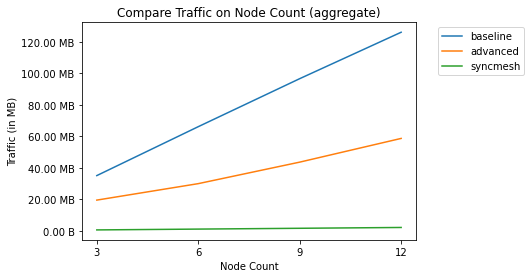

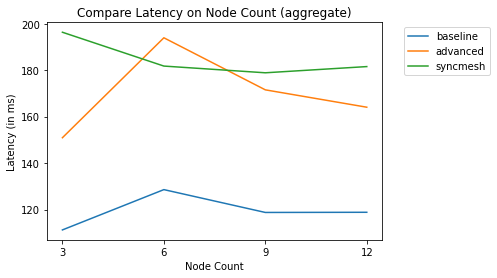

C:\Users\danie\AppData\Local\Temp/ipykernel_20852/2220866219.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


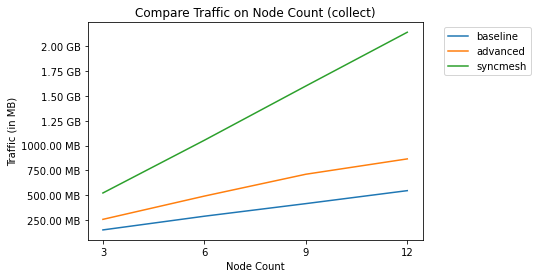

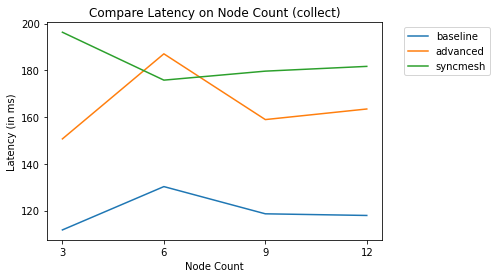

In [ ]:
def drawComparisonGraphTraffic(df, experiment):
    columns = df.columns
    fig, ax = plt.subplots()

    for col in columns: 
        ax.plot(3 + df.index * 3, df[col], label=col)

    # set title and legend
    ax.set_title("Compare Traffic on Node Count (" + experiment + ")")
    ax.set_ylabel("Traffic (in MB)")
    ax.set_xlabel("Node Count")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])

    x_locator = matplotlib.ticker.FixedLocator(np.array(list(range(1, len(df.index) +1))) * 3)
    ax.xaxis.set_major_locator(x_locator)

    fig.savefig("out/node_comparison_traffic_" + experiment + ".png")
    plt.show()

def drawComparisonGraphRtt(df, experiment):
    columns = df.columns
    fig, ax = plt.subplots()

    for col in columns: 
        ax.plot(3 + df.index * 3, df[col], label=col)

    # set title and legend
    ax.set_title("Compare Latency on Node Count (" + experiment + ")")
    ax.set_ylabel("Latency (in ms)")
    ax.set_xlabel("Node Count")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    # ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
    #                 ax.get_yticks(minor=False)])

    x_locator = matplotlib.ticker.FixedLocator(np.array(list(range(1, len(df.index) +1))) * 3)
    ax.xaxis.set_major_locator(x_locator)

    fig.savefig("out/node_comparison_rtt_" + experiment + ".png")
    plt.show()


compare_traffic = {}
compare_rtt = {}
for experiment in ["aggregate", "collect"]:
    compare_traffic[experiment] = {}
    compare_rtt[experiment] = {}
    for scenario in ['baseline', 'advanced', 'syncmesh', "distributed"]:
        compare_traffic[experiment][scenario] = []
        compare_rtt[experiment][scenario] = []
        for node_number in overall_datasets:
            # print(overall_sum_table[node_number]["traffic"][experiment][scenario])
            compare_traffic[experiment][scenario].append(overall_sum_table[node_number]["traffic"][experiment][scenario])
            compare_rtt[experiment][scenario].append(overall_sum_table[node_number]["rtt_mean"][experiment][scenario])


    compare_table_traffic = pd.DataFrame(dict(
            baseline=compare_traffic[experiment]["baseline"],
            advanced=compare_traffic[experiment]["advanced"],
            syncmesh=compare_traffic[experiment]["syncmesh"],
            # distributed=compare_traffic[experiment]["distributed"]
        ))

    compare_table_rtt = pd.DataFrame(dict(
            baseline=compare_rtt[experiment]["baseline"],
            advanced=compare_rtt[experiment]["advanced"],
            syncmesh=compare_rtt[experiment]["syncmesh"],
            # distributed=compare_traffic[experiment]["distributed"]
        ))

    drawComparisonGraphTraffic(compare_table_traffic, experiment)
    drawComparisonGraphRtt(compare_table_rtt, experiment)

C:\Users\danie\AppData\Local\Temp/ipykernel_20852/2725187867.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


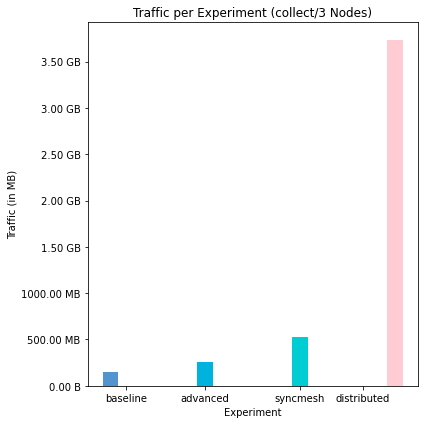

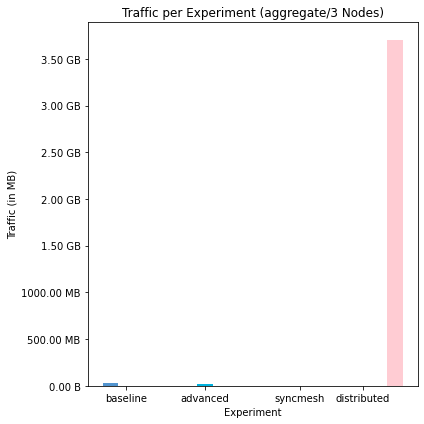

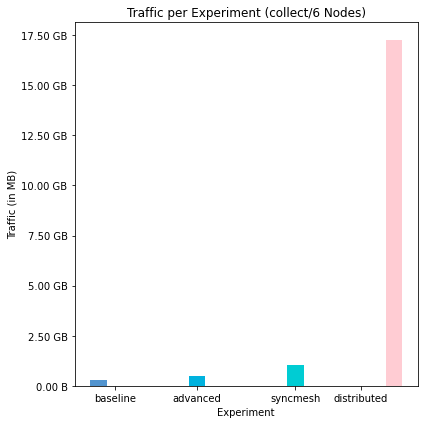

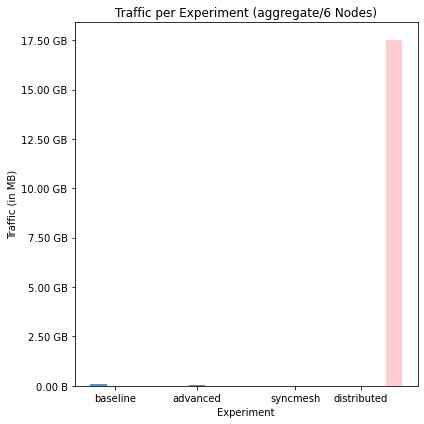

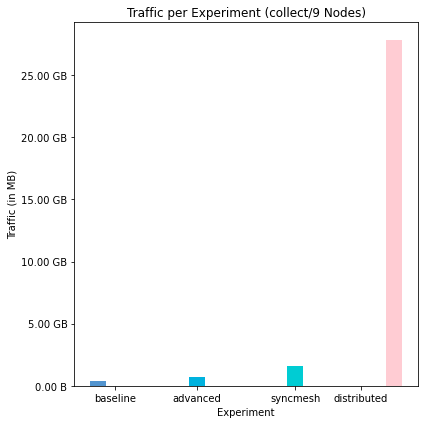

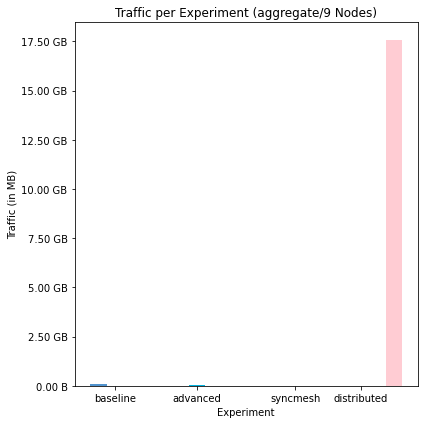

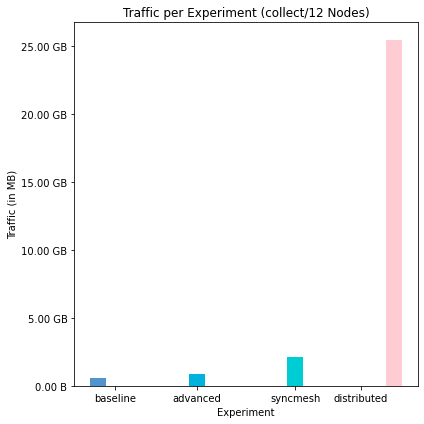

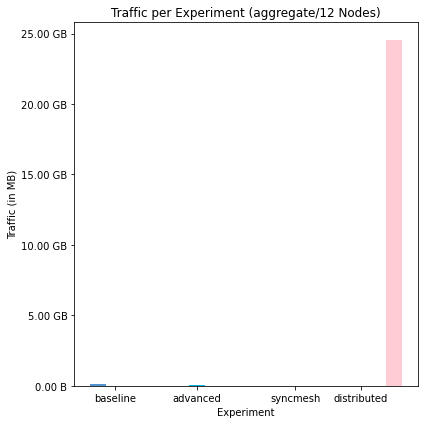

In [ ]:
colors = ["#5294CF", "#00B2DE", "#00CCD3", "#FFCCD3"]
labels = np.array([])



for node_number in overall_datasets:
    for display_scenario in ["collect", "aggregate"]:

        fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))

        for index, source in enumerate(overall_sum_table[node_number]["traffic"][display_scenario]):
            labels = np.append(labels, source)
            # print(sum_table["traffic"]["aggregate"][source])
            bar = ax.bar((6 * index), source, color = colors[index], width = 1)
            # if index > 2:
            #     ax.bar_label(bar, label_type='center', fmt=to_human_readable(source))
        
            # plt.text(X - 0.25 + (0.25 * index * index), y, "labels[index]", ha = 'center',  rotation=90)

        # set title and legend
        ax.set_title('Traffic per Experiment ('+ str(display_scenario) + '/' + str(node_number) + ' Nodes)')
        ax.set_ylabel("Traffic (in MB)")
        ax.set_xlabel("Experiment")
        ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                            ax.get_yticks(minor=False)])
        plt.xticks([1,6,12,16], ['baseline', 'advanced', 'syncmesh', "distributed"])


        # axes = plt.axes([.35, .26, .45, .6])

        # for index, source in enumerate(overall_sum_table[display_nodes]["traffic"][display_scenario]):
        #     if index > 2:
        #         break
        #     labels = np.append(labels, source)
        
        #     bar = axes.bar((0 + 5 * index), source, color = colors[index], width = 1)
        #     # axes.bar_label(bar, label_type='center', fmt=to_human_readable(source))
        #     # axes.plot(x_zoom, y_zoom, c='green')
            

        # axes.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
        #                     axes.get_yticks(minor=False)])
        # plt.xticks([1,6,12], ['baseline', 'advanced', 'syncmesh'])

        # box = ax.get_position()
        # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        # fig.autofmt_xdate()
        fig.savefig(f'out/traffic_overview-'+ display_scenario + "-" + str(node_number) + ' .png')

        plt.show()

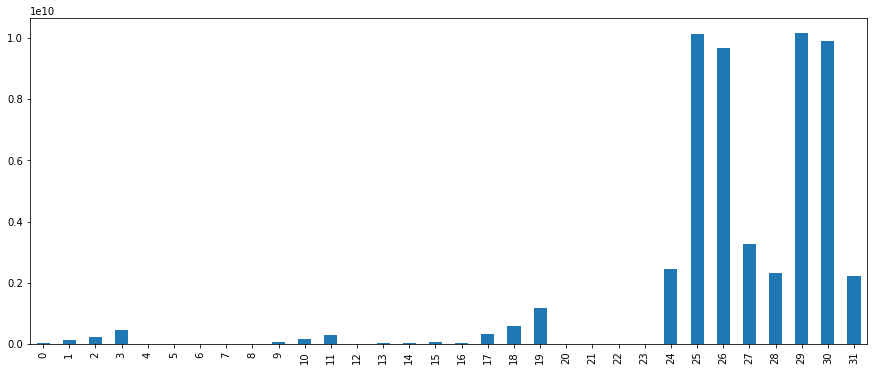

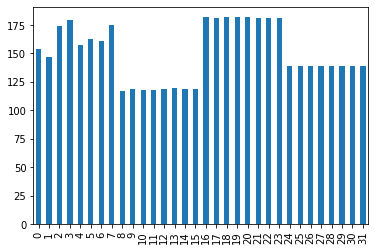

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

analyze_table['traffic'].plot.bar()

plt.show()

analyze_table['rtt'].plot.bar()

plt.show()
# This shows that the traffic is rising evenly accross multiple timeframes.

In [ ]:
def show_traffic_distribution(dataset, timings, name):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    # ax.set_ylim(0,500)
    for key in dataset: 
        test = dataset[key].resample('100ms').agg({"ip.len":'sum'})
        ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
    # for key in fromClientDataset: 
    #     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
    #     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
    # set title and legend

    for timing in list(pd.to_datetime(timings)): 
        ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
    ax.set_title('Scenario: '+name+'\nBandwidth between Nodes')
    ax.set_ylabel("Bytes")
    ax.set_xlabel("Time")
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
    ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                        ax.get_yticks(minor=False)])
    ax.legend(loc='upper left')

    fig.savefig(f"out/bandwidth_between_nodes_{name}.png")
    plt.show()

# for key in node_datasets:
#     show_traffic_distribution(node_datasets[key], datasets[key][1], key)

# Monitoring

In [ ]:
def loadMonitoringDataSet(folder):
    csvfile = os.path.join(Path.cwd(), folder, "monitoring.csv")
    print(csvfile)
    df = pd.read_csv(csvfile)
    df.set_index('timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)

    return df.sort_index()

monitoring_datasets = {}
for source in dataset_sources:
    monitoring_datasets[source] = loadMonitoringDataSet(dataset_sources[source])
    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
monitoring_datasets["syncmesh"].head()

NameError: name 'dataset_sources' is not defined

In [ ]:
# Experiments
def splitMonitoringExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = df.loc[str(timings[index]):str(timings[index + 1])]
    return return_data

monitoring_experiment_datasets = {}
for key in monitoring_datasets:
    print(key)
    print(datasets[key][1])
    monitoring_experiment_datasets[key] = splitMonitoringExperiments(monitoring_datasets[key], datasets[key][1])

setname = "syncmesh"
for key in monitoring_experiment_datasets[setname]:
    print(key, ":", len(monitoring_experiment_datasets[setname][key]))


advanced
['2022-01-12T09:08:48.240007000' '2022-01-12T09:12:15.092391000'
 '2022-01-12T09:16:00.032426000' '2022-01-12T09:20:02.024549000'
 '2022-01-12T09:24:36.836482000' '2022-01-12T09:27:58.776172000'
 '2022-01-12T09:31:18.748376000' '2022-01-12T09:34:38.868401000'
 '2022-01-12T09:38:01.392736000']
baseline
['2022-01-12T09:09:02.042810000' '2022-01-12T09:12:30.242157000'
 '2022-01-12T09:16:20.674311000' '2022-01-12T09:20:34.135818000'
 '2022-01-12T09:25:40.027578000' '2022-01-12T09:29:06.380518000'
 '2022-01-12T09:32:42.631298000' '2022-01-12T09:36:28.526637000'
 '2022-01-12T09:40:36.658520000']
syncmesh
['2022-01-16T15:24:42.660042000' '2022-01-16T15:28:23.152001000'
 '2022-01-16T15:32:33.739899000' '2022-01-16T15:36:56.531947000'
 '2022-01-16T15:41:49.019922000' '2022-01-16T15:45:26.543873000'
 '2022-01-16T15:49:03.883875000' '2022-01-16T15:52:41.956720000'
 '2022-01-16T15:56:19.727659000']
distributed
['2022-01-16T11:59:29.665903000' '2022-01-16T12:07:10.578109000'
 '2022-01-16T1

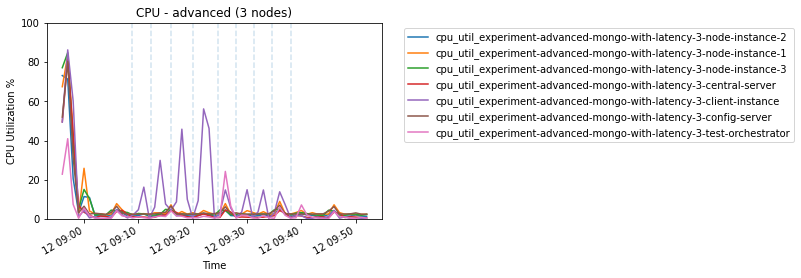

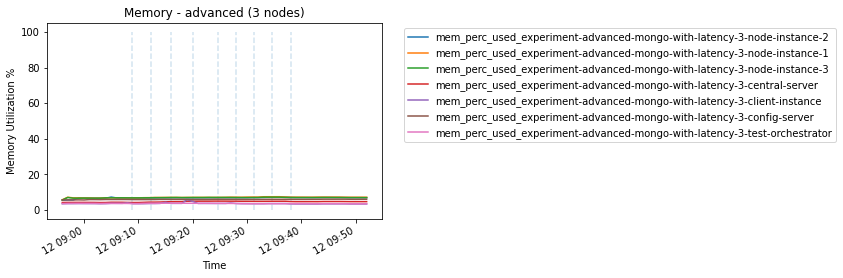

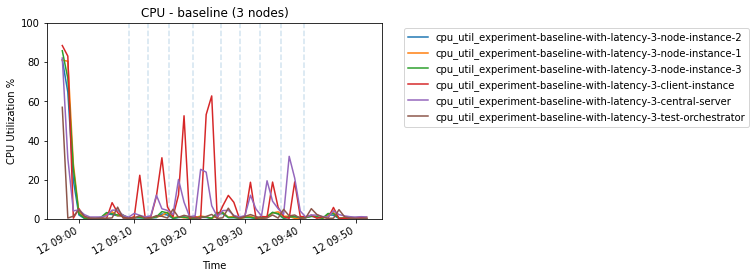

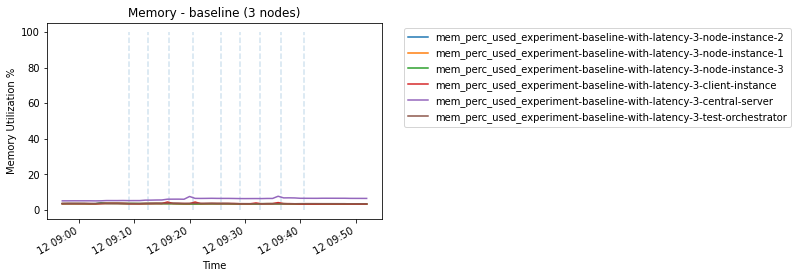

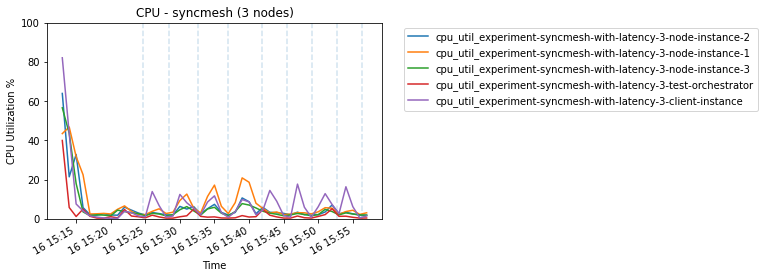

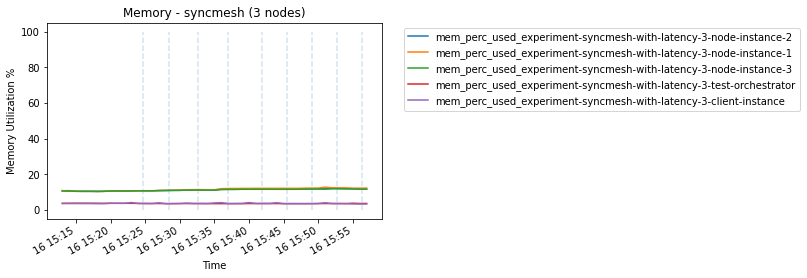

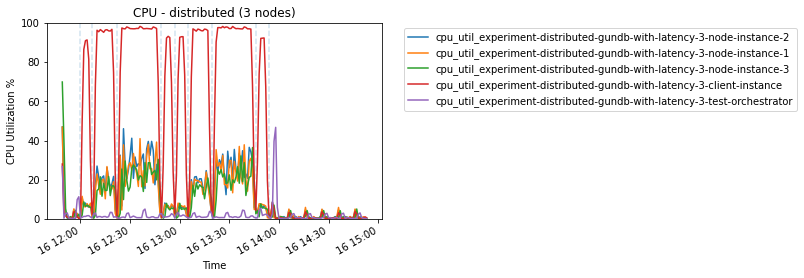

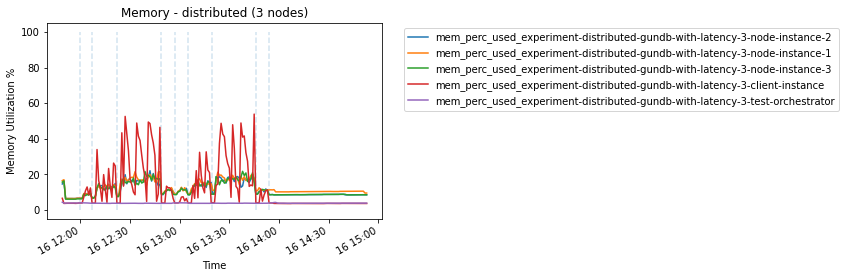

In [ ]:
def drawMonitoringGraphCPU(df, name):
    columns = df.columns
    fig, ax = plt.subplots()
    ax.set_ylim(0,100)

    for col in columns: 
        if col.startswith("cpu_"):
            ax.plot(df.index, df[col]*100, label=col)

    for timing in list(pd.to_datetime(datasets[name][1])): 
        ax.vlines(timing, 0, 100, linestyle='--', alpha=0.2)
    # set title and legend
    ax.set_title('CPU - ' + name + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("CPU Utilization %")
    ax.set_xlabel("Time")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()

    fig.savefig("out/cpu_util_" + name + ".png")
    plt.show()

def drawMonitoringGraphRAM(df, name):
    columns = df.columns
    fig, ax = plt.subplots()
    # ax.set_ylim(0,100)
    max_y = 100
    for col in columns: 
        if col.startswith("mem_perc_used") and "used" in col:
            # print(len(df[col]))
            ax.plot(df.index, df[col], label=col)
            max_y = max(max_y, df[col].max())

    for timing in list(pd.to_datetime(datasets[name][1])): 
        ax.vlines(timing, 0, max_y, linestyle='--', alpha=0.2)
    # set title and legend
    ax.set_title('Memory - ' + name + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("Memory Utilization %")
    ax.set_xlabel("Time")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()

    fig.savefig("out/ram_util_" + name + ".png")
    plt.show()


# drawMonitoringGraphRAM(monitoring_datasets["advanced"], source)

# monitoring_datasets["advanced"]["mem_perc_cached_experiment-advanced-mongo-with-latency-3-central-config-server"].min()
# monitoring_datasets["advanced"]["mem_perc_cached_experiment-advanced-mongo-with-latency-3-node-instance-1"].max()
for source in monitoring_datasets:
    drawMonitoringGraphCPU(monitoring_datasets[source], source)
    drawMonitoringGraphRAM(monitoring_datasets[source], source)


In [ ]:
colors = ["#5294CF", "#00B2DE", "#00CCD3", "#FFCCD3"]
def drawMonitoringCPUComparison(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(15, 6))
    labels = np.array([])
    for index, source in enumerate(experiment_datasets):
        X = np.arange(len(experiment_datasets[source].keys()))
        X_labels = experiment_datasets[source].keys()
        labels = np.append(labels, source)
        sum_cpu_util = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            cpu_util = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("cpu_") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    cpu_util = np.append(cpu_util, [df[col]])
                    # ax.plot(df.index, df[col]*100, label=col)
            # print(cpu_util)
            # print(np.mean(cpu_util))
            # See here for Formula for comparise
            sum_cpu_util = np.append(sum_cpu_util, np.mean(cpu_util) * num_instances)
        # print(sum_cpu_util)
        ax.bar(X - 0.25 + (0.25 * index), sum_cpu_util * 100, color = colors[index], width = 0.25)

    # set title and legend
    ax.set_title('Aggregated CPU Usage' + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("CPU Utilization in %")
    ax.set_ybound(0,100)
    ax.set_xlabel("Experiment")
    ax.legend(labels=labels)
    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig("out/cpu_comparison.png")
    plt.show()

drawMonitoringCPUComparison(monitoring_experiment_datasets)

NameError: name 'monitoring_experiment_datasets' is not defined

[0.10009733 0.16221433 0.11368144 0.11926545 0.1779166  0.1086199
 0.1067236  0.17306355]
[0.03955914 0.11061771 0.10083893 0.14978785 0.06708572 0.08334681
 0.14519101 0.17199422]
[0.0802614  0.16838967 0.17982258 0.22277859 0.09918238 0.07461438
 0.12682933 0.08138204]
[0.17336497 0.44153008 0.71596978 0.14743782 0.12813343 0.46219859
 0.67740271 0.15713578]


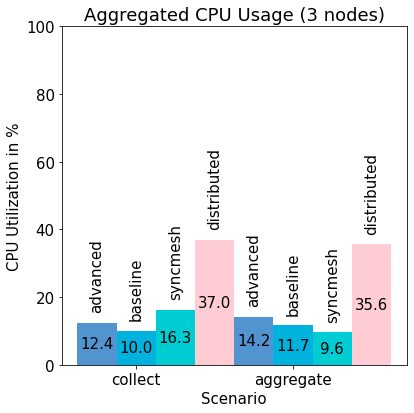

In [ ]:
plt.rcParams.update({'font.size': 15})
# Only use two buckets collect and aggregate
def drawMonitoringCPUComparisonAggregate(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
    labels = np.array([])
    X_labels = np.array(["collect", "aggregate"])
    X = np.arange(2)

    for index, source in enumerate(experiment_datasets):
        labels = np.append(labels, source)
        sum_cpu_util = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            cpu_util = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("cpu_") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    cpu_util = np.append(cpu_util, [df[col]])
                    # ax.plot(df.index, df[col]*100, label=col)
            # print(cpu_util)
            # print(np.mean(cpu_util))
            # See here for Formula for comparise
            sum_cpu_util = np.append(sum_cpu_util, np.mean(cpu_util) * num_instances)

        print(sum_cpu_util)
        y = np.array([sum_cpu_util[0:4].mean(), sum_cpu_util[4:8].mean()])
        bar = ax.bar(X - 0.25 + (0.25 * index), y*100, color = colors[index], width = 0.25)
        ax.bar_label(bar, label_type='center',fmt='%.1f')
        # for y_i in range(len(y)):
        for x_i in range(len(X)):
            plt.text(x_i - 0.25 + (0.25 * index), y[x_i] * 100 +4, labels[index], ha = 'center',  rotation=90)
    # set title and legend
    ax.set_title('Aggregated CPU Usage' + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("CPU Utilization in %")
    ax.set_ybound(0,100)
    ax.set_xlabel("Scenario")
    # ax.legend(labels=labels)

    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig(f'out/cpu_comparison_aggregated_{datasets["baseline"][2]}.png')
    
    plt.show()

drawMonitoringCPUComparisonAggregate(monitoring_experiment_datasets)

[4.73502515e+09 4.84423680e+09 4.89772646e+09 4.93528678e+09
 3.72236698e+09 4.95407923e+09 3.76794317e+09 5.04322048e+09]
[6.29400455 6.4799703 ]
[1.88723610e+09 2.57309901e+09 2.64282931e+09 3.31250483e+09
 2.64175206e+09 1.96340122e+09 2.70366310e+09 2.64729395e+09]
[4.22131544 4.30406727]
[5.00686848e+09 5.14512077e+09 5.23900518e+09 6.79459226e+09
 5.45728922e+09 5.48532224e+09 4.18544026e+09 5.55463066e+09]
[11.28343526 11.92161104]
[7.45595699e+09 2.05650862e+10 4.98227159e+10 9.67300301e+09
 1.08850340e+10 2.24190669e+10 5.10814290e+10 9.94811904e+09]
[13.27502731 14.30905046]


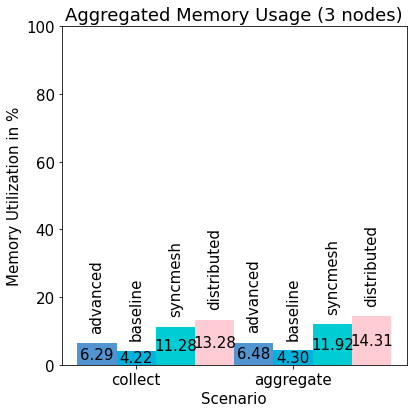

In [ ]:
plt.rcParams.update({'font.size': 15})
# Only use two buckets collect and aggregate
def drawMonitoringRAMComparisonAggregate(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
    labels = np.array([])
    X_labels = np.array(["collect", "aggregate"])
    X = np.arange(2)

    for index, source in enumerate(experiment_datasets):
        labels = np.append(labels, source)
        sum_mem_used = np.array([])
        sum_mem_free = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            mem_used = np.array([])
            mem_perc_used = np.array([])
            mem_free = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("mem_used") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    mem_used = np.append(mem_used, [df[col]])
                if col.startswith("mem_perc_used") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    mem_perc_used = np.append(mem_perc_used, [df[col]])
                if (col.startswith("mem_free") or col.startswith("mem_slab") or col.startswith("mem_cached") or col.startswith("mem_buffered")) and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    mem_free = np.append(mem_free, [df[col]])
            # See here for Formula for comparise
            sum_mem_used = np.append(sum_mem_used, np.sum(mem_used))
            sum_mem_free = np.append(sum_mem_free, np.sum(mem_free))

        print(sum_mem_used)
        y = np.array([sum_mem_used[0:4].sum() / (sum_mem_used[0:4].sum() + sum_mem_free[0:4].sum()) * 100, sum_mem_used[4:8].sum() / (sum_mem_used[4:8].sum() + sum_mem_free[4:8].sum()) * 100])
        print(y)
        bar = ax.bar(X - 0.25 + (0.25 * index), y, color = colors[index], width = 0.25)
        ax.bar_label(bar, label_type='center',fmt='%.2f')
        # for y_i in range(len(y)):
        for x_i in range(len(X)):
            plt.text(x_i - 0.25 + (0.25 * index), y[x_i]+ 4, labels[index], ha = 'center',  rotation=90)
    # set title and legend
    ax.set_title('Aggregated Memory Usage' + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("Memory Utilization in %")
    ax.set_ybound(0,100)
    ax.set_xlabel("Scenario")
    # ax.legend(labels=labels)

    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig(f'out/ram_comparison_aggregated_{datasets["baseline"][2]}.png')
    
    plt.show()

drawMonitoringRAMComparisonAggregate(monitoring_experiment_datasets)

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def convertToTime(s):
    try:
        return (datetime.strptime(s.strip(), "%M:%S.%f") - datetime(1900, 1, 1)).total_seconds()
    except Exception as e:
        return None

def loadTimings(source):
    experiments = ["collect", "aggregate"]
    return_data = {}
    with open(source + "/collect.timings") as f:
        timings = list(chunks(list(filter(None, map(lambda s: convertToTime(s), f.readlines()))), 80))
        
        for index, timing in enumerate(timings): 
            return_data[experiments[index]] = timings[index]
    
    with open(source + "/aggregate.timings") as f:
        timings = list(chunks(list(filter(None, map(lambda s: convertToTime(s), f.readlines()))), 80))

        for index, timing in enumerate(timings): 
            return_data[experiments[index + (int(len(experiments)/2))]] = timings[index]

    return return_data

colors = ["#5294CF", "#00B2DE", "#00CCD3", "#FFCCD3"]
labels = np.array([])

overall_timings_datasets = {}
for node_number in overall_dataset_sources:
    overall_timings_datasets[node_number] = {}
    for source in overall_dataset_sources[node_number]:
        overall_timings_datasets[node_number][source] = loadTimings(overall_dataset_sources[node_number][source])


FileNotFoundError: [Errno 2] No such file or directory: 'data/data-syncmesh-with-latency-3/20220206-13-experiment-syncmesh-with-latency-3/collect.timings'

In [ ]:
matplotlib.rcParams.update({'errorbar.capsize': 6})


compare_timings = {}
for experiment in ["aggregate", "collect"]:
    compare_timings[experiment] = {}
    for scenario in ['baseline', 'advanced', 'syncmesh']: # "distributed"
        compare_timings[experiment][scenario] = {}
        compare_timings[experiment][scenario]["value"] = []
        compare_timings[experiment][scenario]["max"] = []
        compare_timings[experiment][scenario]["min"] = []
        for node_number in overall_timings_datasets:

            y = statistics.median(overall_timings_datasets[node_number][scenario][experiment])
            y_max = max(overall_timings_datasets[node_number][scenario][experiment]) - y
            y_min = abs(min(overall_timings_datasets[node_number][scenario][experiment]) - y)
            # print(overall_sum_table[node_number]["traffic"][experiment][scenario])
            compare_timings[experiment][scenario]["value"].append(y)
            compare_timings[experiment][scenario]["max"].append(y_max)
            compare_timings[experiment][scenario]["min"].append(y_min)





def drawComparisonGraphTimings(df, experiment):
    columns = ['baseline', 'advanced', 'syncmesh']
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))

    for col in columns: 
        #ax.plot(3 + df.index * 3, df[col + "_value"], label=col)
        ax.errorbar(3 + df.index * 3, df[col + "_value"], label=col, yerr = [df[col + "_min"], df[col + "_max"]])
        

    # set title and legend
    ax.set_title("Compare RTT on Node Count (" + experiment + ")")
    ax.set_ylabel("RTT (in seconds)")
    ax.set_xlabel("Node Count")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


    x_locator = matplotlib.ticker.FixedLocator(np.array(list(range(1, len(df.index) +1))) * 3)
    ax.xaxis.set_major_locator(x_locator)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    fig.savefig("out/node_comparison_timings_" + experiment + ".png")
    plt.show()


experiment = "aggregate"
compare_table_timing = pd.DataFrame(dict(
        baseline_value=compare_timings[experiment]["baseline"]["value"],
        baseline_max=compare_timings[experiment]["baseline"]["max"],
        baseline_min=compare_timings[experiment]["baseline"]["min"],
        advanced_value=compare_timings[experiment]["advanced"]["value"],
        advanced_max=compare_timings[experiment]["advanced"]["max"],
        advanced_min=compare_timings[experiment]["advanced"]["min"],
        syncmesh_value=compare_timings[experiment]["syncmesh"]["value"],
        syncmesh_max=compare_timings[experiment]["syncmesh"]["max"],
        syncmesh_min=compare_timings[experiment]["syncmesh"]["min"],
        distributed_value=compare_timings[experiment]["distributed"]["value"],
        distributed_max=compare_timings[experiment]["distributed"]["max"],
        distributed_min=compare_timings[experiment]["distributed"]["min"],
))

drawComparisonGraphTimings(compare_table_timing, experiment)

experiment = "collect"
compare_table_timing = pd.DataFrame(dict(
        baseline_value=compare_timings[experiment]["baseline"]["value"],
        baseline_max=compare_timings[experiment]["baseline"]["max"],
        baseline_min=compare_timings[experiment]["baseline"]["min"],
        advanced_value=compare_timings[experiment]["advanced"]["value"],
        advanced_max=compare_timings[experiment]["advanced"]["max"],
        advanced_min=compare_timings[experiment]["advanced"]["min"],
        syncmesh_value=compare_timings[experiment]["syncmesh"]["value"],
        syncmesh_max=compare_timings[experiment]["syncmesh"]["max"],
        syncmesh_min=compare_timings[experiment]["syncmesh"]["min"],
        distributed_value=compare_timings[experiment]["distributed"]["value"],
        distributed_max=compare_timings[experiment]["distributed"]["max"],
        distributed_min=compare_timings[experiment]["distributed"]["min"],
))

compare_table_timing
drawComparisonGraphTimings(compare_table_timing, experiment)


KeyError: 'syncmesh'